In [89]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from explainers.grad import Gradient
from evaluator import Evaluator

In [90]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [91]:
pre = os.getcwd()

In [92]:
pytorch_model = models.vgg16(pretrained=True)
device = 'cpu'

In [93]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [94]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def L_relu3(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        return x


net = Net()

In [95]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [96]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('ML_Models/Saved_Models/ANN/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'ML_Models/Saved_Models/ANN/cifar_torchvision.pt')

Using existing trained model


In [97]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

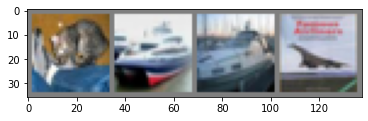

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship


In [98]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [99]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [100]:
for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    break

In [101]:
grad = Gradient(net)
grad_exp = grad.get_explanation(inputs, labels)
grad_exp.shape

torch.Size([4, 3, 32, 32])

In [102]:
labels.dtype

torch.int64

In [103]:
inputs.dtype

torch.float32

In [104]:
class MockPerturbationClass():
    def __init__(self):
        self.temp = 'mocked'
        
    def get_perturbed_inputs(self, x, top_k, explanation_x, num_samples):
        samples = []
        for n in range(num_samples):
            samples.append(torch.randn(size=x.shape))
        return torch.stack(samples)

In [105]:
L_conv1 = net.conv1
L_relu3 = net.L_relu3

In [106]:
'''
class OrchestratorClass():
    def __init__(self, explanation_method, explainee_model, perturbation_method, evaluation_metric: str):
        
        self.explanation_method = explanation_method
        self.perturbation_method = perturbation_method
        self.explainee_model = explainee_model
        self.evaluation_metric = evaluation_metric
        
         
    def get_explanation(self, explainee_input):
        
        Return explanation for the given model and input data point
        
        explanation = self.explanation_method.get_explanation(explainee_input, inputs, labels, self.explainee_model)
        
        return explanation 
    
    

    def _to_input_dict(self, sample: torch.FloatTensor, label: torch.tensor, 
                       is_image_data: bool=True, p_norm: int=2, top_k: int=1) -> dict:
        
        
        
        input_dict = {}
        
        if image_data:
            input_dict['x'] = sample.unsqueeze(0)
        else:
            input_dict['x'] = sample

        input_dict['explainer'] = self.explanation_method
        input_dict['explanation_x'] = explanation
        input_dict['perturbation'] = self.perturbation_method

        
        input_dict['L_map'] = L_relu3
        
        
        input_dict['p_norm'] = p_norm
        input_dict['top_k'] = top_k
        input_dict['y'] = label.detach().item()
        
        input_dict['y_pred'] = torch.max(self.explainee_model(input_dict['x']), 1).indices.detach().item()

        return input_dict

    def evaluate_explanation(self, explainee_input, ground_truth_dict=None):


        Evaluates explanation
        
        x = inputs[i]
        y = labels[i]
        self._to_input_dict(x, y, inputs, labels, tabular=True)

        return evaluations
'''

"\nclass OrchestratorClass():\n    def __init__(self, explanation_method, explainee_model, perturbation_method, evaluation_metric: str):\n        \n        self.explanation_method = explanation_method\n        self.perturbation_method = perturbation_method\n        self.explainee_model = explainee_model\n        self.evaluation_metric = evaluation_metric\n        \n         \n    def get_explanation(self, explainee_input):\n        \n        Return explanation for the given model and input data point\n        \n        explanation = self.explanation_method.get_explanation(explainee_input, inputs, labels, self.explainee_model)\n        \n        return explanation \n    \n    \n\n    def _to_input_dict(self, sample: torch.FloatTensor, label: torch.tensor, \n                       is_image_data: bool=True, p_norm: int=2, top_k: int=1) -> dict:\n        \n        \n        \n        input_dict = {}\n        \n        if image_data:\n            input_dict['x'] = sample.unsqueeze(0)\n     

In [107]:
'''
# params for synthetic data    
params = {
'n_samples': 1000,
'dim': 20,
'n_clusters': 10,
'distance_to_center': 6,
'test_size': 0.25,
'upper_weight': 1,
'lower_weight': -1,
'seed': 564,
'sigma': None,
'sparsity': 0.25
}


loader_train_gauss, loader_test_gauss = loaders.return_loaders(data_name='gaussian', is_tabular=True,
                                                               batch_size=5, gauss_params=params)


gauss_train_input = loader_train_gauss.dataset.ground_truth_dict
data_iter = iter(loader_train_gauss)
input, labels, weights, masks, masked_weights, probs, cluster_idx = data_iter.next()

model_path = 'ML_Models/Saved_Models/ANN/gaussian_lr_0.002_acc_0.89.pt'
ann = model_ann.ANN(20, hidden_layer_1=100, num_of_classes=1)
ann.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 

explanation_method = get_explanation()
explainee_model = ann
evaluation_metric = 'f1@k'
perturbation_method

orchestra = OrchestratorClass(explanation_method, explainee_model, evaluation_metric, perturbation_method)
'''

"\n# params for synthetic data    \nparams = {\n'n_samples': 1000,\n'dim': 20,\n'n_clusters': 10,\n'distance_to_center': 6,\n'test_size': 0.25,\n'upper_weight': 1,\n'lower_weight': -1,\n'seed': 564,\n'sigma': None,\n'sparsity': 0.25\n}\n\n\nloader_train_gauss, loader_test_gauss = loaders.return_loaders(data_name='gaussian', is_tabular=True,\n                                                               batch_size=5, gauss_params=params)\n\n\ngauss_train_input = loader_train_gauss.dataset.ground_truth_dict\ndata_iter = iter(loader_train_gauss)\ninput, labels, weights, masks, masked_weights, probs, cluster_idx = data_iter.next()\n\nmodel_path = 'ML_Models/Saved_Models/ANN/gaussian_lr_0.002_acc_0.89.pt'\nann = model_ann.ANN(20, hidden_layer_1=100, num_of_classes=1)\nann.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) \n\nexplanation_method = get_explanation()\nexplainee_model = ann\nevaluation_metric = 'f1@k'\nperturbation_method\n\norchestra = OrchestratorClass

In [108]:
input_dict = {}

input_dict['x'] = inputs[0].unsqueeze(0)
input_dict['explainer'] = grad
input_dict['explanation_x'] = grad.get_explanation(inputs, labels)[0]
perturbation = MockPerturbationClass()
input_dict['perturbation'] = perturbation
input_dict['L_map'] = L_relu3
input_dict['p_norm'] = 2
input_dict['top_k'] = 1
input_dict['y'] = labels[0].detach().item()
input_dict['y_pred'] = torch.max(net(inputs[0].unsqueeze(0)), 1).indices.detach().item()

In [109]:
inputs.shape

torch.Size([4, 3, 32, 32])

In [110]:
def to_input_dict(self, inputs, labels, tabular=True):
    
    input_dict = {}

    input_dict['x'] = inputs[0].unsqueeze(0)
    input_dict['explainer'] = grad
    input_dict['explanation_x'] = self.explanation_method.get_explanation(inputs, labels)[0]
    perturbation = MockPerturbationClass()
    input_dict['perturbation'] = perturbation
    input_dict['L_map'] = L_relu3
    input_dict['p_norm'] = 2
    input_dict['top_k'] = 1
    input_dict['y'] = labels[0].detach().item()
    input_dict['y_pred'] = torch.max(net(inputs[0].unsqueeze(0)), 1).indices.detach().item()
    
    return input_dict

In [111]:
evaluator = Evaluator(input_dict)
stability, stability_ratios, rep_diffs, x_diffs, exp_diffs = evaluator.eval_relative_stability(delta=1e10)

In [112]:
stability

nan

In [113]:
x_diffs

[1165.4142,
 917.32074,
 774.867,
 855.88513,
 910.2006,
 861.2303,
 868.153,
 672.3487,
 951.70306,
 802.99316,
 885.5538,
 571.43646,
 1023.54895,
 781.71564,
 925.37994,
 1011.82043,
 916.86145,
 874.142,
 670.418,
 721.90375,
 826.7138,
 722.6005,
 1033.1472,
 922.31714,
 770.45917,
 980.83813,
 726.8382,
 865.2515,
 757.72577,
 584.57697,
 1028.8606,
 1073.7543,
 991.36237,
 725.5873,
 690.5589,
 718.6854,
 908.1405,
 873.29944,
 940.4685,
 834.28156,
 702.318,
 884.3806,
 833.40564,
 902.5446,
 908.24036,
 723.0918,
 769.8937,
 869.08685,
 943.328,
 655.4141,
 796.6824,
 918.321,
 1126.5675,
 839.71124,
 807.26764,
 730.7883,
 907.57886,
 1006.93176,
 874.4584,
 651.7878,
 765.9315,
 824.94495,
 737.34863,
 597.1584,
 970.9138,
 1117.3066,
 886.0883,
 899.6591,
 838.3593,
 585.80096,
 877.0578,
 854.2511,
 1013.6995,
 996.3924,
 869.53314,
 645.4301,
 911.8502,
 832.01245,
 747.0058,
 829.4821,
 674.744,
 720.8981,
 1146.8872,
 806.47375,
 981.5256,
 663.90076,
 715.89075,
 728.1

In [114]:
## output of ReLu3

rep_diffs

[7.3186493,
 5.781203,
 5.8339224,
 5.209068,
 7.494627,
 7.9787006,
 6.1198335,
 7.17532,
 7.675952,
 15.178774,
 10.807332,
 5.735431,
 7.8260975,
 11.212874,
 7.9716606,
 5.75737,
 7.535344,
 7.149913,
 6.464566,
 6.3138556,
 9.263494,
 6.1709003,
 14.57537,
 10.544187,
 11.856489,
 8.381669,
 6.2920465,
 7.037812,
 8.491072,
 5.4016614,
 11.942797,
 5.733699,
 5.976117,
 5.2099166,
 10.173788,
 7.173657,
 9.287292,
 7.178534,
 6.0423183,
 12.138535,
 5.5887218,
 7.208973,
 10.930621,
 9.473107,
 8.7365885,
 5.668838,
 5.12234,
 13.035855,
 9.303516,
 11.099979,
 7.3612256,
 5.822211,
 13.42535,
 6.7800035,
 10.545009,
 9.321807,
 6.1271114,
 6.0402904,
 6.170882,
 8.387548,
 10.254461,
 8.898237,
 7.617425,
 7.9310865,
 15.655804,
 9.3869,
 6.2667136,
 6.425278,
 7.0966516,
 7.766191,
 6.518595,
 11.4649105,
 7.394905,
 6.9302115,
 6.3986216,
 6.798546,
 6.6379046,
 12.153631,
 14.757267,
 5.828326,
 5.9173307,
 6.4192004,
 9.37142,
 8.655089,
 6.826239,
 8.012067,
 5.8849626,
 11.

In [115]:
## output of first conv layer

rep_diffs

[7.3186493,
 5.781203,
 5.8339224,
 5.209068,
 7.494627,
 7.9787006,
 6.1198335,
 7.17532,
 7.675952,
 15.178774,
 10.807332,
 5.735431,
 7.8260975,
 11.212874,
 7.9716606,
 5.75737,
 7.535344,
 7.149913,
 6.464566,
 6.3138556,
 9.263494,
 6.1709003,
 14.57537,
 10.544187,
 11.856489,
 8.381669,
 6.2920465,
 7.037812,
 8.491072,
 5.4016614,
 11.942797,
 5.733699,
 5.976117,
 5.2099166,
 10.173788,
 7.173657,
 9.287292,
 7.178534,
 6.0423183,
 12.138535,
 5.5887218,
 7.208973,
 10.930621,
 9.473107,
 8.7365885,
 5.668838,
 5.12234,
 13.035855,
 9.303516,
 11.099979,
 7.3612256,
 5.822211,
 13.42535,
 6.7800035,
 10.545009,
 9.321807,
 6.1271114,
 6.0402904,
 6.170882,
 8.387548,
 10.254461,
 8.898237,
 7.617425,
 7.9310865,
 15.655804,
 9.3869,
 6.2667136,
 6.425278,
 7.0966516,
 7.766191,
 6.518595,
 11.4649105,
 7.394905,
 6.9302115,
 6.3986216,
 6.798546,
 6.6379046,
 12.153631,
 14.757267,
 5.828326,
 5.9173307,
 6.4192004,
 9.37142,
 8.655089,
 6.826239,
 8.012067,
 5.8849626,
 11.

In [116]:
evaluator.perturbation